# Class 9: Data Science 2 — Querying SQL Tables for Network Construction

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

## Today's Dataset

Today we're going to focus on getting a lot of reps in in order to learn things about our dataset. It will involve a lot of hands-on coding and less of me talking at you. 

The dataset we'll be using today comes from SNAP; it's the [Reddit Hyperlinks dataset](https://snap.stanford.edu/data/soc-RedditHyperlinks.html). The paper that arose from this dataset, by Kumar et al., can be found [here](https://cs.stanford.edu/~srijan/pubs/conflict-paper-www18.pdf). 

Posts in one subreddit can link out to another subreddit for myriad reasons, including hatred, shared interests, and many things in between. I've somewhat simplified the dataset we'll be working with today, but it has some interesting elements nonetheless. For one, each link has a `TIMESTAMP` attribute that indicates when the hyperlink was created. There's also a `LINK_SENTIMENT` attribute that indicates whether the sentiment of the post or title that contained the link was positive (1) or negative (-1). The `link_source` attribute indicates whether the link came from the title or the body of the post. 

First let's get connected to our database again. 

In [1]:
from sqlalchemy import create_engine
import pandas as pd

my_creds = []
with open('../../../shared/student_mysql_credentials.txt', 'r') as f:
    for line in f.readlines():
        my_creds.append(line.strip())

hostname="mysql-0005"
dbname="PHYS7332"
uname=my_creds[0]
pwd=my_creds[1]

engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
                           .format(host=hostname, db=dbname,
                                   user=uname,pw=pwd))


### Looking at the data
Next, we'll take a look at the dataset. Let's look at the first 10 rows just to get a sense of what the data looks like.

In [2]:
qu = 'SELECT * FROM reddit_hyperlinks LIMIT 10;'
pd.read_sql(qu, engine)

,index,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,link_source
0,0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,body
1,1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,body
2,2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,body
3,3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,body
4,4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,body
5,5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,body
6,6,locationbot,legaladvice,1u4wfes,2014-01-07 20:17:41,1,body
7,7,indiefied,aww,1u50pos,2014-03-03 17:00:35,1,body
8,8,posthardcore,bestof2013,1u5ccus,2013-12-31 23:16:20,1,body
9,9,posthardcore,corejerk,1u5ccus,2013-12-31 23:16:20,1,body


Which linkage pops up the most often in our dataset? Let's find out. 

We're going to start by grouping our data by the combination of `SOURCE_SUBREDDIT` and `TARGET_SUBREDDIT`. 

Then we'll count how many rows each grouping contains and note that, along with the names of the source & target subreddits. 

Finally, we'll sort by the number of total linkages that occurred.

In [3]:
qu = """
SELECT COUNT(*) as count_links, SOURCE_SUBREDDIT, TARGET_SUBREDDIT \
FROM reddit_hyperlinks \
GROUP BY SOURCE_SUBREDDIT, TARGET_SUBREDDIT ORDER BY count_links;
"""
df_link_counts = pd.read_sql(qu, engine)
df_link_counts.sort_values('count_links', ascending=False)

,count_links,SOURCE_SUBREDDIT,TARGET_SUBREDDIT
339642,548,trendingsubreddits,changelog
339641,478,moronicmondayandroid,android
339640,306,subredditdrama,news
339639,305,atletico,soccer
339638,301,writingprompts,askreddit
...,...,...,...
113214,1,canadianbusiness,canada
113213,1,smashsisters,sketchdaily
113212,1,delusionalartists,leagueoflegends
113211,1,telus,canada


### Degree Distribution
You might also be curious about the in- and out- degree distribution of this network. Can you compute the in- and out- degree distributions using the SQL table? In this case, we want to know how many distinct subreddits each other subreddit linked to, not how many **times** a subreddit was linked to.

Text(0.5, 1.0, 'out-degree distribution')

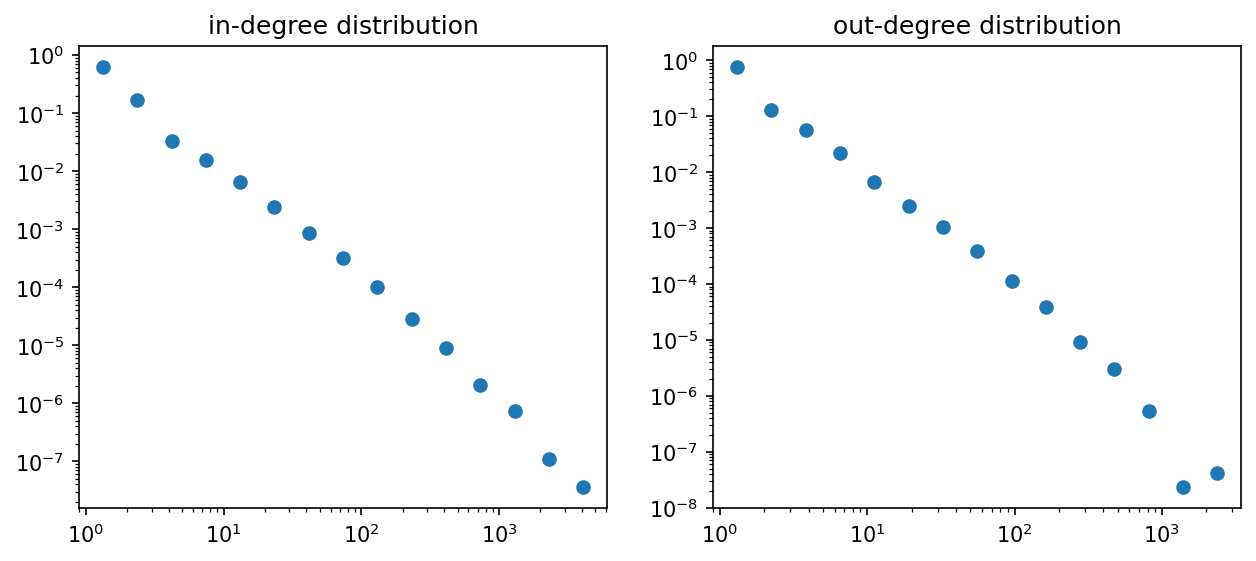

In [4]:
# Your Turn!
import matplotlib.pyplot as plt
import numpy as np

qu_in = """
SELECT COUNT(DISTINCT SOURCE_SUBREDDIT) as count_links, TARGET_SUBREDDIT \
FROM reddit_hyperlinks \
GROUP BY TARGET_SUBREDDIT ORDER BY count_links;
"""
df_in = pd.read_sql(qu_in, engine)

qu_out = """
SELECT COUNT(DISTINCT TARGET_SUBREDDIT) as count_links, SOURCE_SUBREDDIT \
FROM reddit_hyperlinks \
GROUP BY SOURCE_SUBREDDIT ORDER BY count_links;
"""
df_out = pd.read_sql(qu_out, engine)


in_degree_list = df_in['count_links'].tolist()
out_degree_list = df_out['count_links'].tolist()

def degree_distribution(k, number_of_bins=15, log_binning=True, density=True):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    k: a list of nodes' degrees

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 
        
    Returns
    -------
    hist, bins (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """
    
    kmax = np.max(k)                    # get the maximum degree
    
    
    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0,np.log10(kmax+1),number_of_bins+1)
        bin_edges = []
        for ix in range(len(bins) - 1):
            bin_edges.append(np.exp((np.log(bins[ix])+np.log(bins[ix + 1]))/2))
    else:
        bins = np.linspace(0,kmax+1,num=number_of_bins+1)
        bin_edges = []
        for ix in range(len(bins) - 1):
            bin_edges.append((bins[ix] + bins[ix + 1]) / 2)
    # Step 3: Then we can compute the histogram using numpy
    hist, _ = np.histogram(k,bins,density=density)

    return bin_edges, hist
    
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=150)

in_degree_bin_edges, in_degree_freqs = degree_distribution(in_degree_list)
out_degree_bin_edges, out_degree_freqs = degree_distribution(out_degree_list)
ax[0].loglog(in_degree_bin_edges, in_degree_freqs, 'o')
ax[0].set_title('in-degree distribution')
ax[1].loglog(out_degree_bin_edges, out_degree_freqs, 'o')
ax[1].set_title('out-degree distribution')

### Temporal Dynamics of In-Links
Now let's look at how in-links to a specific subreddit show up over time. Do they tend to accumulate steadily over time, or do they arrive in bursts? Let's look at the in-links to /r/askreddit. We'll use the handy `pd.to_datetime` function to convert our string timestamps to datetime objects.

In [5]:

qu_inlinks = """
SELECT TIMESTAMP, SOURCE_SUBREDDIT \
FROM reddit_hyperlinks \
WHERE TARGET_SUBREDDIT='askreddit';
"""
df_inlinks = pd.read_sql(qu_inlinks, engine)

df_inlinks['ts_parsed_rounded'] = df_inlinks['TIMESTAMP'].apply(pd.to_datetime).dt.floor('30d')


We've just taken the 30-day floor (roughly a month) of the timestamps we computed; this is so we aggregate our in-link counts to every 30 days

Text(0.5, 1.0, '/r/askreddit in-link frequency over time')

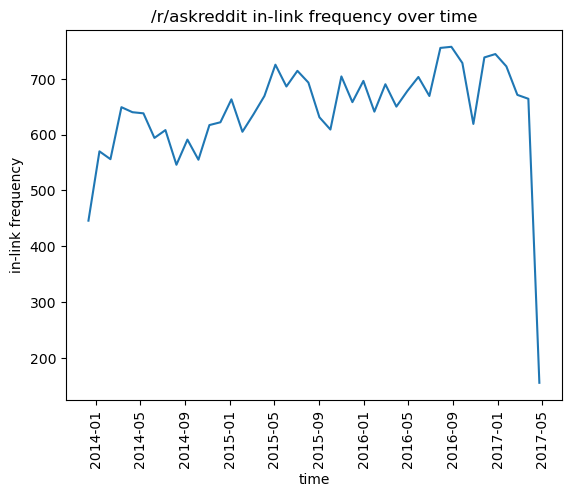

In [6]:
count_per_30d = df_inlinks.groupby('ts_parsed_rounded').agg({'TIMESTAMP': 'count'})
plt.plot(count_per_30d.index, count_per_30d['TIMESTAMP'])
plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('in-link frequency')
plt.title('/r/askreddit in-link frequency over time')

Next, we'll look at /r/subredditdrama's out-links. Can you make the same plot but for /r/subredditdrama's out-links? 

Text(0.5, 1.0, '/r/subredditdrama out-link frequency over time')

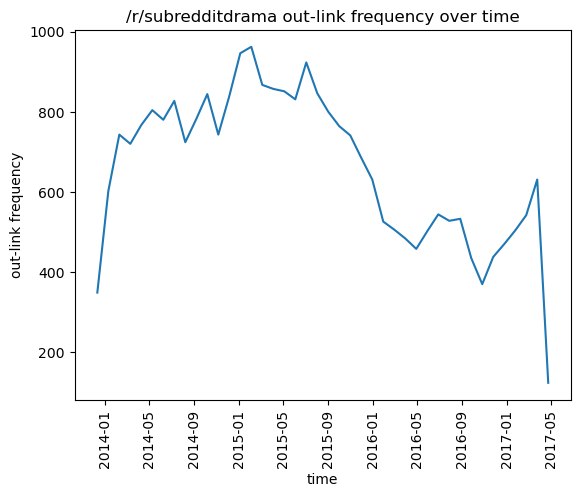

In [7]:
# Your Turn!

qu_outlinks = """
SELECT TIMESTAMP, TARGET_SUBREDDIT \
FROM reddit_hyperlinks \
WHERE SOURCE_SUBREDDIT='subredditdrama';
"""
df_outlinks = pd.read_sql(qu_outlinks, engine)

df_outlinks['ts_parsed_rounded'] = df_outlinks['TIMESTAMP'].apply(pd.to_datetime).dt.floor('30d')

count_per_30d = df_outlinks.groupby('ts_parsed_rounded').agg({'TIMESTAMP': 'count'})
plt.plot(count_per_30d.index, count_per_30d['TIMESTAMP'])
plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('out-link frequency')
plt.title('/r/subredditdrama out-link frequency over time')

Recall that links can have sentiment attached to them, either positive (1) or negative (-1). Let's look at the number of positive and negative out-links (so plot each one in a different color in the same plot) for /r/subredditdrama over the entire time period. 

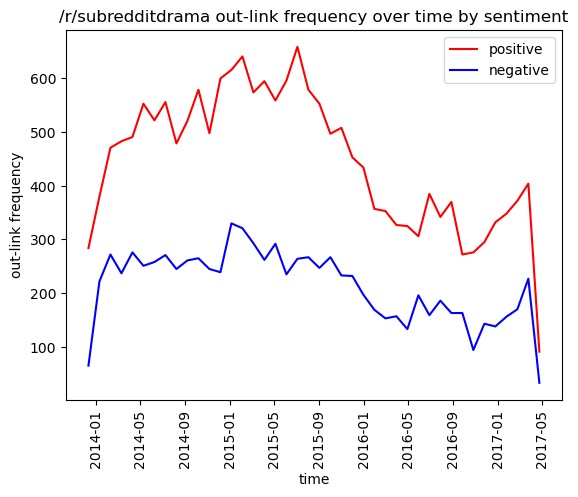

In [9]:
# Your Turn!

qu_pos_outlinks = """
SELECT TIMESTAMP, TARGET_SUBREDDIT \
FROM reddit_hyperlinks \
WHERE SOURCE_SUBREDDIT='subredditdrama' \
AND LINK_SENTIMENT=1;
"""
df_pos_outlinks = pd.read_sql(qu_pos_outlinks, engine)

df_pos_outlinks['ts_parsed_rounded'] = df_pos_outlinks[
    'TIMESTAMP'
    ].apply(pd.to_datetime).dt.floor('30d')

pos_count_per_30d = df_pos_outlinks.groupby(
    'ts_parsed_rounded').agg({'TIMESTAMP': 'count'})
plt.plot(
    pos_count_per_30d.index, 
    pos_count_per_30d['TIMESTAMP'],
    color='red',
    label='positive',)

qu_neg_outlinks = """
SELECT TIMESTAMP, TARGET_SUBREDDIT \
FROM reddit_hyperlinks \
WHERE SOURCE_SUBREDDIT='subredditdrama' \
AND LINK_SENTIMENT=-1;
"""
df_neg_outlinks = pd.read_sql(qu_neg_outlinks, engine)

df_neg_outlinks['ts_parsed_rounded'] = df_neg_outlinks[
    'TIMESTAMP'
    ].apply(pd.to_datetime).dt.floor('30d')

neg_count_per_30d = df_neg_outlinks.groupby(
    'ts_parsed_rounded').agg({'TIMESTAMP': 'count'})
plt.plot(
    neg_count_per_30d.index, 
    neg_count_per_30d['TIMESTAMP'],
    color='blue',
    label='negative',)
plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('out-link frequency')
plt.title('/r/subredditdrama out-link frequency over time by sentiment')
plt.legend()

Now let's turn to temporal changes in the network. Can you plot the network's in- and out-degree distributions for 2014, 2015, and 2016? Hint: the [`EXTRACT`](https://www.w3schools.com/Sql/func_mysql_extract.asp) function in SQL may come in handy here. 

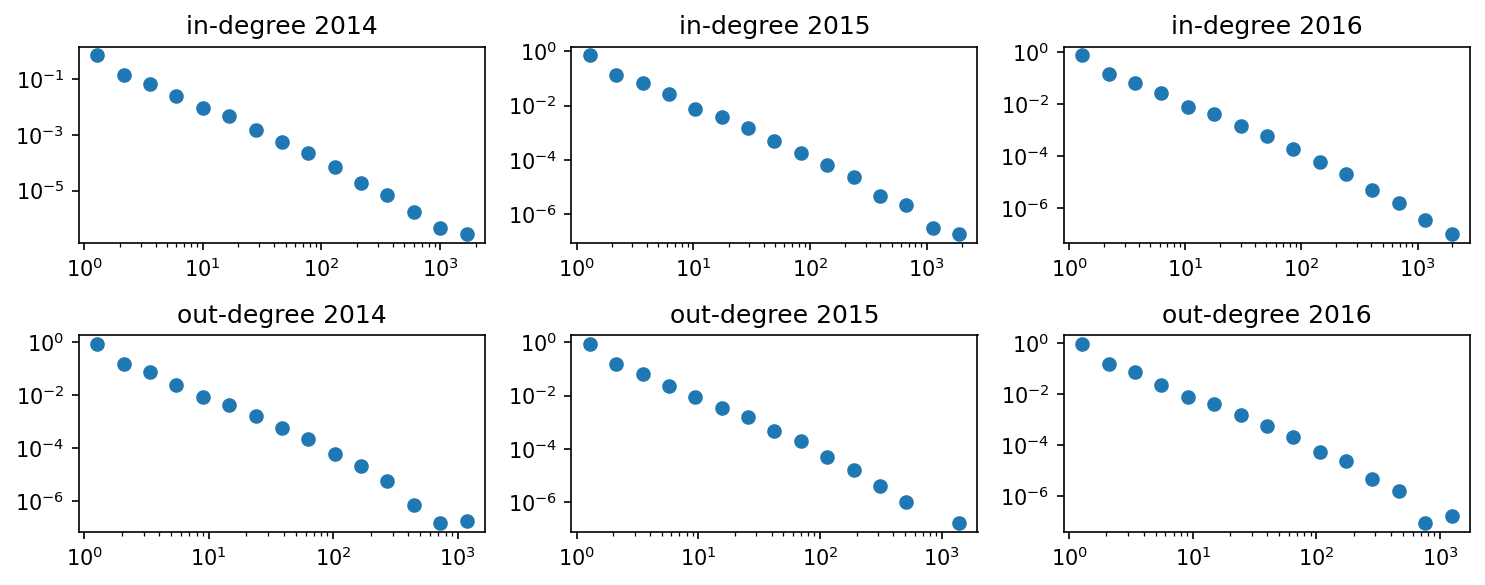

In [17]:

fig, ax = plt.subplots(2,3,figsize=(10,4),dpi=150)

# Your Turn!
for ix, year in enumerate([2014, 2015, 2016]):
    qu_in = """
    SELECT COUNT(DISTINCT SOURCE_SUBREDDIT) as count_links, TARGET_SUBREDDIT \
    FROM reddit_hyperlinks \
    WHERE EXTRACT(year FROM TIMESTAMP) = {} \
    GROUP BY TARGET_SUBREDDIT ORDER BY count_links;
    """.format(str(year))
    df_in = pd.read_sql(qu_in, engine)
    
    qu_out = """
    SELECT COUNT(DISTINCT TARGET_SUBREDDIT) as count_links, SOURCE_SUBREDDIT \
    FROM reddit_hyperlinks \
    WHERE EXTRACT(year FROM TIMESTAMP) = {} \
    GROUP BY SOURCE_SUBREDDIT ORDER BY count_links; 
   
    """.format(str(year))
    df_out = pd.read_sql(qu_out, engine)
    
    
    in_degree_list = df_in['count_links'].tolist()
    out_degree_list = df_out['count_links'].tolist()

    in_degree_bin_edges, in_degree_freqs = degree_distribution(in_degree_list)
    out_degree_bin_edges, out_degree_freqs = degree_distribution(out_degree_list)
    ax[0, ix].loglog(in_degree_bin_edges, in_degree_freqs, 'o')
    ax[0, ix].set_title('in-degree {}'.format(str(year)))
    ax[1, ix].loglog(out_degree_bin_edges, out_degree_freqs, 'o')
    ax[1, ix].set_title('out-degree {}'.format(str(year)))
plt.tight_layout()

### Local Clustering
Pick a subreddit -- any subreddit (I suggest picking one that has a lot of links to keep things interesting). Can you figure out what its local clustering coefficient is in 2014, 2015, and 2016? Let's assume the graph is unweighted for now, so one hyperlink from subreddit A to subreddit B in 2014 is the same as 10 separate hyperlinks from A to B in the same year. We will also assume the graph is undirected for this exercise. 

In [5]:
# Your Turn
def compute_clustering(subreddit_name, engine):
    """
    Given the name of a subreddit and a SQL connection engine,
    return the local clustering coefficient of the subreddit,
    considering the network as undirected, OR 
    raise appropriate errors.

    subreddit_name: string; valid name of a subreddit
    engine: sqlalchemy engine object

    returns: the local clustering coefficient of the subreddit
    """

    qu = """
    SELECT DISTINCT SOURCE_SUBREDDIT, TARGET_SUBREDDIT \
    FROM reddit_hyperlinks \
    WHERE SOURCE_SUBREDDIT = '{}' OR TARGET_SUBREDDIT = '{}'
    """.format(subreddit_name, subreddit_name)
    df = pd.read_sql(qu, engine)
    unique_subreddits = list(set(
        df['SOURCE_SUBREDDIT'].tolist() + \
        df['TARGET_SUBREDDIT'].tolist())
    )
    tot_pairs = 0
    tot_linked = 0
    for s1 in unique_subreddits:
        for s2 in unique_subreddits:
            if s1 > s2:
                tot_pairs += 1
                qu_is_linked = """
                SELECT * FROM reddit_hyperlinks WHERE (\
                SOURCE_SUBREDDIT = '{}' AND TARGET_SUBREDDIT = '{}') \
                OR (SOURCE_SUBREDDIT = '{}' AND TARGET_SUBREDDIT = '{}')
                """.format(s1, s2, s2, s1)
                df_linked = pd.read_sql(qu_is_linked, engine)
                if len(df_linked) > 0:
                    tot_linked += 1
    print(tot_linked / tot_pairs)
compute_clustering('amitheasshole', engine)

0.3684210526315789
